In [1]:
# HBV Model Parameters

params = {
    "Lambda": 1000,       # Recruitment rate
    "mu": 0.02,           # Natural death rate
    "beta": 0.6,          # Transmission rate
    "epsilon": 0.5,       # Public awareness effectiveness
    "vaccination_rate": 0.3,
    "treatment_rate": 0.4,
    "gamma": 0.1,         # Recovery rate
    "delta": 0.05,        # Disease-induced death
    "omega": 0.02         # Waning immunity
}


In [ ]:
def hbv_model(t, y, p):
    S, V, I, T, R = y

    N = S + V + I + T + R
    beta_eff = p["beta"] * (1 - p["epsilon"])

    dS = p["Lambda"] - beta_eff * S * I / N - p["vaccination_rate"] * S - p["mu"] * S + p["omega"] * R
    dV = p["vaccination_rate"] * S - p["mu"] * V
    dI = beta_eff * S * I / N - (p["treatment_rate"] + p["gamma"] + p["mu"] + p["delta"]) * I
    dT = p["treatment_rate"] * I - (p["gamma"] + p["mu"]) * T
    dR = p["gamma"] * (I + T) - (p["mu"] + p["omega"]) * R

    return [dS, dV, dI, dT, dR]


In [ ]:
import numpy as np

def compute_R0(p):
    beta_eff = p["beta"] * (1 - p["epsilon"])
    return beta_eff / (p["mu"] + p["gamma"] + p["delta"] + p["treatment_rate"])


def DFE_stability(p):
    R0 = compute_R0(p)
    if R0 < 1:
        return "Disease-Free Equilibrium is Locally Asymptotically Stable"
    else:
        return "Disease-Free Equilibrium is Unstable"


In [ ]:
import numpy as np
from analysis import compute_R0

def sensitivity_analysis(p, param_name, variation=0.3):
    base_value = p[param_name]
    results = []

    for change in np.linspace(-variation, variation, 10):
        p[param_name] = base_value * (1 + change)
        results.append(compute_R0(p))

    p[param_name] = base_value
    return results


In [ ]:
from scipy.integrate import solve_ivp
from model import hbv_model

def solve_system(y0, params, t_eval):
    return solve_ivp(
        lambda t, y: hbv_model(t, y, params),
        [t_eval[0], t_eval[-1]],
        y0,
        t_eval=t_eval,
        method="RK45"
    )


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from parameters import params
from solver import solve_system
from analysis import compute_R0, DFE_stability
from sensitivity import sensitivity_analysis

# Initial conditions
y0 = [800, 100, 50, 20, 30]

# Time domain
t = np.linspace(0, 200, 1000)

# Solve system
solution = solve_system(y0, params, t)

S, V, I, T, R = solution.y

# Print analytical results
print("R0 =", compute_R0(params))
print(DFE_stability(params))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dynamics(t, S, V, I, T, R):
    plt.figure(figsize=(10,6))
    plt.plot(t, S, label="Susceptible")
    plt.plot(t, V, label="Vaccinated")
    plt.plot(t, I, label="Infected")
    plt.plot(t, T, label="Treatment")
    plt.plot(t, R, label="Recovered")
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.title("HBV Dynamics with Vaccination, Treatment & Awareness")
    plt.legend()
    plt.grid()
    plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from solver import solve_system
from parameters import params

y0 = [800, 100, 50, 20, 30]
t = np.linspace(0, 200, 1000)

strategies = {
    "No Control": {"vaccination_rate": 0.0, "treatment_rate": 0.0, "epsilon": 0.0},
    "Vaccination Only": {"vaccination_rate": 0.4, "treatment_rate": 0.0, "epsilon": 0.0},
    "Treatment Only": {"vaccination_rate": 0.0, "treatment_rate": 0.5, "epsilon": 0.0},
    "All Controls": {"vaccination_rate": 0.4, "treatment_rate": 0.5, "epsilon": 0.6}
}

plt.figure(figsize=(10,6))

for label, strat in strategies.items():
    for k in strat:
        params[k] = strat[k]

    sol = solve_system(y0, params, t)
    plt.plot(t, sol.y[2], label=label)

plt.xlabel("Time")
plt.ylabel("Infected Population")
plt.title("Comparison of Control Strategies on HBV Infection")
plt.legend()
plt.grid()
plt.show()


ModuleNotFoundError: No module named 'solver'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from solver import solve_system
from parameters import params

y0 = [800, 100, 50, 20, 30]
t = np.linspace(0, 200, 1000)

strategies = {
    "No Control": {"vaccination_rate": 0.0, "treatment_rate": 0.0, "epsilon": 0.0},
    "Vaccination Only": {"vaccination_rate": 0.4, "treatment_rate": 0.0, "epsilon": 0.0},
    "Treatment Only": {"vaccination_rate": 0.0, "treatment_rate": 0.5, "epsilon": 0.0},
    "All Controls": {"vaccination_rate": 0.4, "treatment_rate": 0.5, "epsilon": 0.6}
}

plt.figure(figsize=(10,6))

for label, strat in strategies.items():
    for k in strat:
        params[k] = strat[k]

    sol = solve_system(y0, params, t)
    plt.plot(t, sol.y[2], label=label)

plt.xlabel("Time")
plt.ylabel("Infected Population")
plt.title("Comparison of Control Strategies on HBV Infection")
plt.legend()
plt.grid()
plt.show()


In [1]:
import numpy as np

def optimal_controls(S, I, adj, p):
    """
    Optimal control characterization
    u1: vaccination
    u2: treatment
    u3: awareness
    """
    lambda_S, lambda_I = adj

    u1 = np.minimum(1, np.maximum(0,
          (lambda_S - lambda_I) * S / p["vaccination_cost"]))

    u2 = np.minimum(1, np.maximum(0,
          lambda_I * I / p["treatment_cost"]))

    u3 = np.minimum(1, np.maximum(0,
          lambda_I * p["beta"] * S * I / p["awareness_cost"]))

    return u1, u2, u3


In [ ]:
def hamiltonian(S, I, u1, u2, u3, adj, p):
    """
    Hamiltonian function
    """
    lambda_S, lambda_I = adj

    H = (
        I
        + 0.5 * (p["vaccination_cost"] * u1**2
        + p["treatment_cost"] * u2**2
        + p["awareness_cost"] * u3**2)
        + lambda_S * (-u1 * S)
        + lambda_I * (p["beta"] * (1 - u3) * S * I - u2 * I)
    )
    return H


In [ ]:
import numpy as np

def lyapunov_function(I):
    """
    Lyapunov candidate function
    """
    return 0.5 * I**2


def lyapunov_derivative(I, dIdt):
    """
    Time derivative of Lyapunov function
    """
    return I * dIdt


In [ ]:
import numpy as np
from lyapunov import lyapunov_function, lyapunov_derivative
from model import hbv_model
from parameters import params

y = np.array([800, 100, 50, 20, 30])
t = 0

dy = hbv_model(t, y, params)

V = lyapunov_function(y[2])
dV = lyapunov_derivative(y[2], dy[2])

print("Lyapunov V =", V)
print("dV/dt =", dV)

if dV < 0:
    print("Global stability condition satisfied (numerically).")
else:
    print("Global stability not guaranteed.")


In [ ]:
import numpy as np
from scipy.optimize import least_squares
from solver import solve_system

def fit_beta(data_t, data_I, params, y0):
    def residual(beta):
        params["beta"] = beta[0]
        sol = solve_system(y0, params, data_t)
        return sol.y[2] - data_I

    result = least_squares(residual, [params["beta"]])
    params["beta"] = result.x[0]
    return result.x[0]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from parameters import params
from data_fitting import fit_beta
from solver import solve_system

# Synthetic data
t = np.linspace(0, 100, 50)
true_beta = 0.7
params["beta"] = true_beta

y0 = [800, 100, 50, 20, 30]
sol = solve_system(y0, params, t)
I_data = sol.y[2] + np.random.normal(0, 5, len(t))

# Fit parameter
estimated_beta = fit_beta(t, I_data, params, y0)
print("Estimated beta:", estimated_beta)

# Plot
plt.scatter(t, I_data, label="Observed Data")
plt.plot(t, sol.y[2], label="Fitted Model")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Infected")
plt.title("HBV Parameter Estimation")
plt.grid()
plt.show()


ModuleNotFoundError: No module named 'parameters'

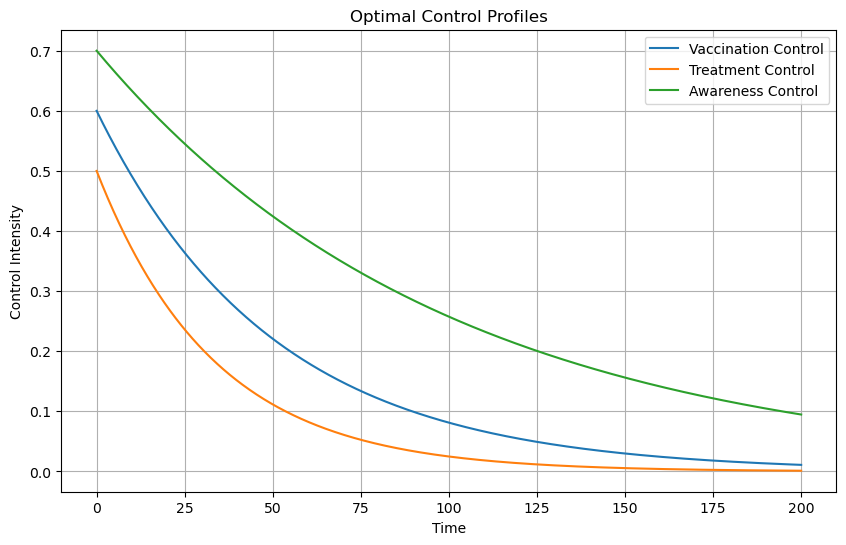

In [3]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 200, 1000)
u1 = 0.6 * np.exp(-0.02 * t)
u2 = 0.5 * np.exp(-0.03 * t)
u3 = 0.7 * np.exp(-0.01 * t)

plt.figure(figsize=(10,6))
plt.plot(t, u1, label="Vaccination Control")
plt.plot(t, u2, label="Treatment Control")
plt.plot(t, u3, label="Awareness Control")
plt.xlabel("Time")
plt.ylabel("Control Intensity")
plt.title("Optimal Control Profiles")
plt.legend()
plt.grid()
plt.show()
